# Nonlinear adaptive control

In this example, we will use the PES learning rule
to learn the effects of gravity, applied to a 2-joint arm.

This example requires the ABR_Control library, available here: https://github.com/abr/abr_control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
from nengo.processes import WhiteSignal
import nengo_loihi
nengo_loihi.set_defaults()

## Creating the controller and visualizing the arm in Nengo



In [2]:
from abr_control.arms import twolink as arm
from abr_control.controllers import OSC

# set the initial position of the arm
robot_config = arm.Config(use_cython=True)
arm_sim = arm.ArmSim(robot_config=robot_config, dt=1e-3, q_init=[.95, 2.0])

# get the arm segment lengths, for visualization
L = []
for ii in range(int(robot_config.L.shape[0] / 2)):
    L.append(np.sum(robot_config.L[ii*2:ii*2+2]))

# create an operational space controller
ctrlr = OSC(robot_config, kp=10, kv=7, vmax=10)

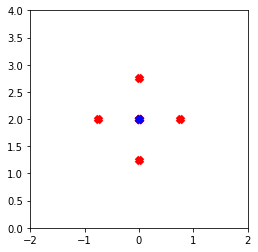

In [3]:
# create a set of targets to reach to
n_reaches = 4
distance = .75
center = [0, 2.0]
end_points = [
    [distance * np.cos(theta) + center[0],
     distance * np.sin(theta) + center[1]]
    for theta in np.linspace(0, 2*np.pi, n_reaches+1)][:-1]
targets = []
for ep in end_points:
    targets.append(center)
    targets.append(ep)
targets = np.array(targets)

plt.plot(targets[:, 0], targets[:,1], 'rx', mew=5)
plt.plot(center[0], center[1], 'bx', mew=5)
plt.xlim([-2, 2])
plt.ylim([0, 4])
plt.gca().set_aspect('equal')

In [4]:
runtime = 20.0  # how many seconds to run our simulations for

with nengo.Network(label="Nonlinear adaptive control") as model:

    def gen_target(t):
        return targets[int(t / 2) % len(targets)]
    target_node = nengo.Node(output=gen_target, size_out=2)

    def gen_u(t, x):
        return ctrlr.generate(q=x[:2], dq=x[2:4], target_pos=np.hstack([x[4:6], 0]))
    osc_node = nengo.Node(output=gen_u, size_in=6, size_out=2)

    # create input nodes
    def arm_func(t, x):
        u = x[:2]
        u_adapt = x[2:4] * 10
        u += u_adapt

        arm_sim.send_forces(u)
        data = np.hstack([
            arm_sim.q[0], arm_sim.q[1],
            arm_sim.dq[0], arm_sim.dq[1],
            arm_sim.x]) # data returned from node to model

        return data
    arm_node = nengo.Node(output=arm_func, size_in=4)

    # hook up the OSC controller to the arm simulation
    nengo.Connection(osc_node, arm_node[:2])
    nengo.Connection(arm_node[:4], osc_node[:4])
    # send in the targets to the arm simulation and controller
    nengo.Connection(target_node, osc_node[4:6])
    
    probe_target = nengo.Probe(target_node)
    probe_hand = nengo.Probe(arm_node[4:6])

Loading cython function from joint0[0,0,0]_Tx ...
Loading cython function from joint1[0,0,0]_Tx ...
Loading cython function from EE[0,0,0]_Tx ...


In [5]:
with nengo.Simulator(model) as sim:
    sim.run(runtime)
baseline_t = sim.trange()
baseline_data = sim.data

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Loading cython function from EE[0,0,0]_J ...
Loading cython function from M ...
Loading cython function from g ...


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

(<matplotlib.axes._subplots.AxesSubplot at 0x7f28acbc8a58>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f28acb5ad68>)

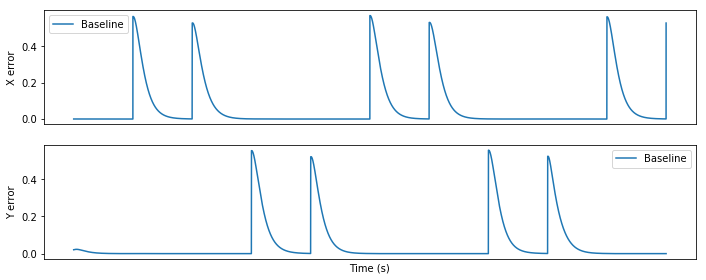

In [6]:
def calculate_error(data):
    return (data[probe_target] - data[probe_hand])**2
baseline_error = calculate_error(baseline_data)

def plot_data(t_set, data_set, label_set):
    plt.figure(figsize=(10, 4))
    plt.title("Distance to target")
    
    ax1 = plt.subplot(2, 1, 1)
    plt.xticks([])
    plt.ylabel('X error')
    
    ax2 = plt.subplot(2, 1, 2)
    plt.xticks([])
    plt.ylabel('Y error')
    plt.xlabel("Time (s)")
    
    plt.tight_layout()
    
    for t, data, label in zip(t_set, data_set, label_set):
        ax1.plot(t, data[:, 0], label=label)
        ax2.plot(t, data[:, 1], label=label)
    
    ax1.legend()
    ax2.legend()
    
    return ax1, ax2

plot_data(
    [baseline_t],
    [baseline_error],
    ['Baseline'])

In [7]:
with model:
    # calculate and add in gravity along y axis
    gravity = np.array([0, -9.8, 0, 0, 0, 0])
    M0g = np.dot(robot_config._M_LINKS[0], gravity)
    M1g = np.dot(robot_config._M_LINKS[1], gravity)
    def gravity_func(t, q):
        g = np.dot(robot_config.J('link1', q=q).T, M0g)
        g += np.dot(robot_config.J('link2', q=q).T, M1g)
        return g
    gravity_node = nengo.Node(gravity_func, size_in=2, size_out=2)
    # connect perturbation to arm
    nengo.Connection(arm_node[:2], gravity_node)
    nengo.Connection(gravity_node, arm_node[:2])


In [8]:
arm_sim.reset()
with nengo.Simulator(model) as sim:
    sim.run(runtime)
gravity_t = sim.trange()
gravity_data = sim.data

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Loading cython function from link1[0,0,0]_J ...
Loading cython function from link2[0,0,0]_J ...


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

(<matplotlib.axes._subplots.AxesSubplot at 0x7f28acaecef0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f28ac783cf8>)

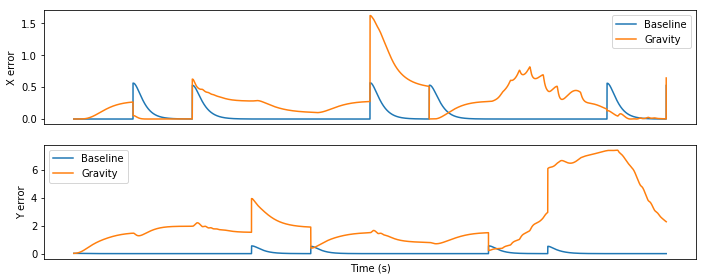

In [9]:
gravity_error = calculate_error(gravity_data)
plot_data(
    [baseline_t, gravity_t],
    [baseline_error, gravity_error],
    ['Baseline', 'Gravity'])

In [10]:
with model:
    # create ensemble to adapt to unmodeled dynamics
    adapt = nengo.Ensemble(n_neurons=1000, dimensions=2, radius=np.sqrt(2))
    scale_node = nengo.Node(
        output=lambda t, x: robot_config.scaledown('q', x), size_in=2, size_out=2)
    nengo.Connection(arm_node[:2], scale_node) # to send target info to ensemble
    nengo.Connection(scale_node, adapt)

    # connect ens to arm
    learn_conn = nengo.Connection(adapt, arm_node[2:4],
                                  function=lambda x: np.zeros(2),
                                  learning_rule_type=nengo.PES(1e-6),
                                  synapse=0.05)
    nengo.Connection(osc_node, learn_conn.learning_rule, transform=-1)

In [11]:
arm_sim.reset()
with nengo.Simulator(model) as sim:
    sim.run(runtime)
adapt_t = sim.trange()
adapt_data = sim.data

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

(<matplotlib.axes._subplots.AxesSubplot at 0x7f28acf5b048>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f28a7fda518>)

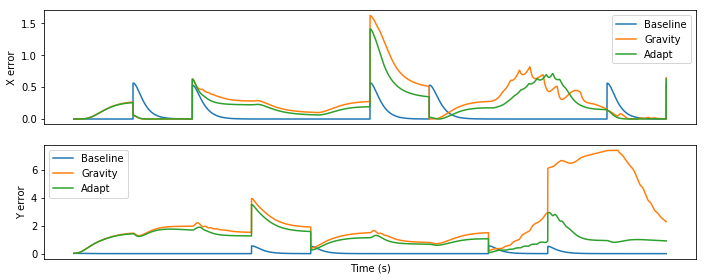

In [12]:
adapt_error = calculate_error(adapt_data)
gravity_error = calculate_error(gravity_data)
plot_data(
    [baseline_t, gravity_t, adapt_t],
    [baseline_error, gravity_error, adapt_error],
    ['Baseline', 'Gravity', 'Adapt'])

## Running the network with Nengo Loihi

Note that learning is not implemented correctly
on the simulator yet; please see the attached
`.pdf` plots generated on Loihi hardware instead.

In [13]:
arm_sim.reset()
with nengo_loihi.Simulator(model) as sim:
    sim.run(runtime)
adapt_loihi_t = sim.trange()
adapt_loihi_data = sim.data

/home/tdewolf/Dropbox/code/nengo-loihi/nengo_loihi/loihi_api.py:450: UserWarning: Lost 5 extra bits in weight rounding
  warnings.warn("Lost %d extra bits in weight rounding" % (-s2,))


(<matplotlib.axes._subplots.AxesSubplot at 0x7f28a7c88550>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f28adace908>)

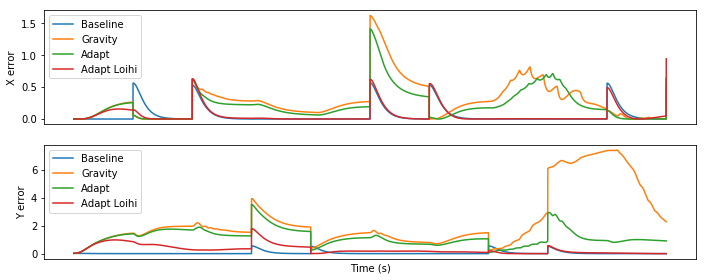

In [14]:
adapt_loihi_error = calculate_error(adapt_loihi_data)
plot_data(
    [baseline_t, gravity_t, adapt_t, adapt_loihi_t],
    [baseline_error, gravity_error, adapt_error, adapt_loihi_error],
    ['Baseline', 'Gravity', 'Adapt', 'Adapt Loihi'])